#  OpenEO Use Case 2: Multi–source phenology toolbox
Use case implemented by VITO.

## Official description
This use case concentrates on data fusion tools, time-series generation and phenological
metrics using Sentinel-2 data. It will be tested on several back-end platforms by pilot users from
the Action against Hunger and the International Centre for Integrated Mountain Development.
The here tested processes depend on the availability of orthorectified Sentinel-2 surface re-
flectance data including per pixel quality masks.

## Overview

In this use case, the goal is to derive phenology information from Sentinel-2 time series data.
In this case, phenology is defined by:
- Start of season, a date and the corresponding value of the biophysical indicator
- The maximum value of the growing curve for the indicator
- End of season, a date and the corresponding value of the biophysical indicator

Multiple biophysical indicators exist. But in this use case, the enhanced vegitation index (EVI) is used.

We start by importing the necessary packages, and defining an area of interest.
During the algorithm development phase, we work on a limited study field, so that we can use
the direct execution capabilities of OpenEO to receive feedback on the implemented changes.


(3.057030657924054, 50.99958367677388, 3.058236553549667, 51.00226308446294)

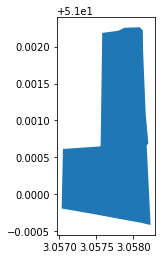

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt 
from rasterio.plot import show, show_hist
import rasterio

from shapely.geometry import Polygon

from openeo import ImageCollection

import openeo
import logging
import os
from pathlib import Path
import json

import numpy as np
import pandas as pd
import geopandas as gpd

import scipy.signal

#enable logging in requests library
from openeo.rest.imagecollectionclient import ImageCollectionClient

start = "2018-05-01"
end = "2018-10-01"

date = "2018-08-17"

parcels = gpd.read_file('potato_field.geojson')
parcels.plot()
polygon = parcels.geometry[0]

minx,miny,maxx,maxy = polygon.bounds

#enlarge bounds, to also have some data outside of our parcel
#minx -= 0.001
#miny -= 0.001
#maxx+=0.001
#maxy+=0.001
polygon.bounds


Connect to the OpenEO backend, and create a Sentinel-2 datacube containing 10M reflectance bands.

We do not yet specify a time range, this allows us to play around with different time ranges later on.


In [3]:
session = openeo.session("nobody", "http://openeo.vgt.vito.be/openeo/0.4.0")

#retrieve the list of available collections
collections = session.list_collections()
s2_radiometry = session.imagecollection("CGS_SENTINEL2_RADIOMETRY_V102_001") \
                    .filter_bbox(west=minx,east=maxx,north=maxy,south=miny,crs="EPSG:4326")


## Preprocessing step 1: EVI computation
Create an EVI data cube, based on reflectance bands. 
The formula for the EVI index can be expressed using plain Python.

The bands retrieved from the backend are unscaled reflectance values with a valid
range between 0 and 10000. 


In [4]:

B02 = s2_radiometry.band('2')
B04 = s2_radiometry.band('4')
B08 = s2_radiometry.band('8')

evi_cube_nodate = (2.5 * (B08 - B04)) / ((B08 + 6.0 * B04 - 7.5 * B02) + 10000.0*1.0)

evi_cube = evi_cube_nodate.filter_temporal(start,end)

#write graph to json, as example
def write_graph(graph, filename):    
    with open(filename, 'w') as outfile:  
        json.dump(graph, outfile,indent=4)
write_graph(evi_cube.graph,"evi_cube.json")

<div class="alert alert-block alert-success">
No actual processing has occurred until now, we have just been building a workflow consisting of multiple steps. In OpenEO, this workflow is representation is called a process graph. This allows your workflow to be exchanged between multiple systems.

The figure below shows this in a graphical representation. 

![EVI Process graph](https://open-eo.github.io/openeo-api/img/pg-example.png "Process graph")
</div>


CPU times: user 7.86 ms, sys: 2.69 ms, total: 10.5 ms
Wall time: 4.06 s


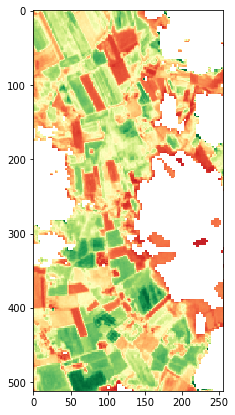

In [27]:
def show_image(cube,cmap='RdYlGn'):
    %time cube.filter_temporal(date,date).download("temp%s.tiff"%date,format='GTIFF')
    with rasterio.open("temp%s.tiff"%date) as src:
        band_temp = src.read(1)
    fig, (ax) = plt.subplots(1,1, figsize=(7,7))
    show(band_temp,ax=ax,cmap=cmap,vmin=0,vmax=1)
show_image(evi_cube_nodate)

### Preprocessing step 2: Cloud masking
In Sen2cor sceneclassification these values are relevant for phenology:
- 4: vegetated
- 5: not-vegetated
Everything else is cloud, snow, water, shadow ...

In OpenEO, the mask function will mask every value that is set to True.


In [7]:
s2_sceneclassification = session.imagecollection("S2_FAPAR_SCENECLASSIFICATION_V102_PYRAMID") \
                    .filter_bbox(west=minx,east=maxx,north=maxy,south=miny,crs="EPSG:4326")

mask = s2_sceneclassification.band('classification')

mask = (mask != 4) & (mask !=5)
mask


Masks produced by sen2cor still include a lot of unwanted clouds and shadow. This problem usually occurs in the proximity of detected clouds, so we try to extend our mask. To do that, we use a bit of fuzzy logic: blur the binary mask using a gaussian so that our mask gives us an indication of how close to a cloud we are.

By adjusting the window size, we can play around with how far from the detected clouds we want to extend our mask.
A 30 pixel kernel applied to a 10M resolution image will cover a 300m area. 

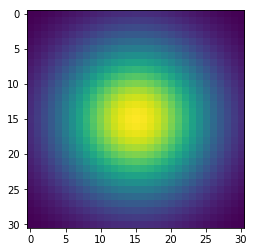

In [8]:
def makekernel(iwindowsize):            
            kernel_vect = scipy.signal.windows.gaussian(iwindowsize, std = iwindowsize/4.0, sym=True)
            kernel = np.outer(kernel_vect, kernel_vect)
            kernel = kernel / kernel.sum()            
            return kernel        
        
plt.imshow(makekernel(31))

Use the apply_kernel OpenEO process:
https://open-eo.github.io/openeo-api/v/0.4.0/processreference/#apply_kernel

In [9]:
fuzzy_mask = mask.apply_kernel(makekernel(29))
mask_extended = fuzzy_mask > 0.1

In [10]:
write_graph(mask_extended.graph,"mask.json")

To evaluate our masking code, we download some reference images:


In [11]:
mask_for_date = mask_extended.filter_temporal(date,date)

In [12]:
%time fuzzy_mask.filter_temporal(date,date).download("mask%s.tiff"%date,format='GTIFF')
#s2_sceneclassification.filter_temporal(date,date).download("scf%s.tiff"%date,format='GTIFF')
%time evi_cube_nodate.filter_temporal(date,date).download("unmasked%s.tiff"%date,format='GTIFF')
%time evi_cube_nodate.filter_temporal(date,date).mask(rastermask=mask_for_date,replacement=np.nan).download("masked%s.tiff"%date,format='GTIFF')

CPU times: user 14.4 ms, sys: 3.66 ms, total: 18 ms
Wall time: 12.6 s
CPU times: user 8.89 ms, sys: 1.08 ms, total: 9.97 ms
Wall time: 2.39 s
CPU times: user 14.6 ms, sys: 2.99 ms, total: 17.6 ms
Wall time: 9.79 s


In [13]:
with rasterio.open("unmasked%s.tiff"%date) as src:
    band_unmasked = src.read(1)

with rasterio.open("masked%s.tiff"%date) as src:
    band_masked = src.read(1)
    
with rasterio.open("mask%s.tiff"%date) as src:
    band_mask = src.read(1)

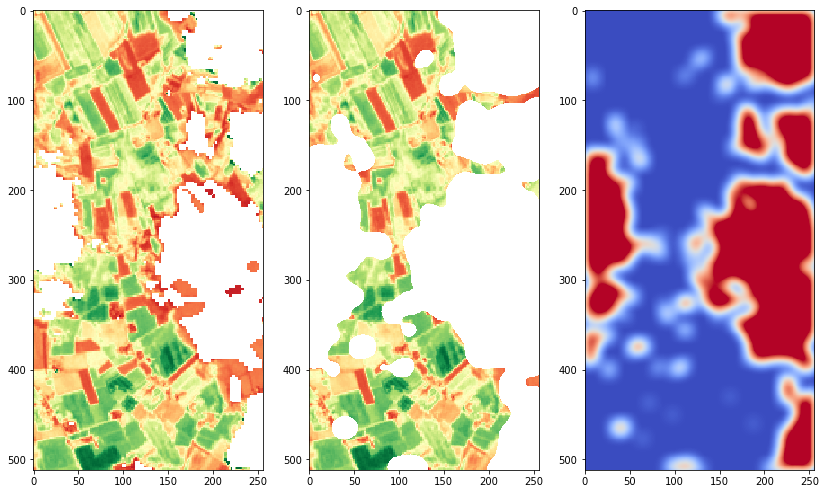

In [14]:
fig, (axr, axg,axb) = plt.subplots(1,3, figsize=(14,14))

show(band_unmasked,ax=axr,cmap='RdYlGn',vmin=0,vmax=1)
show(band_masked,ax=axg,cmap='RdYlGn',vmin=0,vmax=1)
show(band_mask,ax=axb,cmap='coolwarm',vmin=0.0,vmax=0.8)


We can look under the hood of OpenEO, to look at the process graph that is used to encode our workflow:

In [15]:
evi_cube_masked = evi_cube.mask(rastermask=mask_extended.filter_temporal(start,end),replacement=np.nan)

#### Creating a viewing service

OpenEO allows us to turn a datacube into a WMTS viewing service:


In [29]:
service = evi_cube_masked.tiled_viewing_service(type='WMTS',style={'colormap':'RdYlGn'})
print(service)

{'url': 'http://openeo.vgt.vito.be/openeo/services/5269f809-d234-46c3-a13f-1c733c9da575/service/wmts'}


Extract an unsmoothed timeseries, this allows us to evaluate the intermediate result.
For further analysis, smoothing will be needed.


In [16]:
%time
timeseries_raw_dc = evi_cube.polygonal_mean_timeseries(polygon)
timeseries_raw = pd.Series(timeseries_raw_dc.execute(),name="evi_raw")
#timeseries are provided as an array, because of bands, so unpack
timeseries_raw = timeseries_raw.apply(pd.Series)
timeseries_raw.columns = ["evi_raw"]
timeseries_raw.head(15)

CPU times: user 4 µs, sys: 8 µs, total: 12 µs
Wall time: 29.1 µs


,evi_raw
2018-05-01T00:00:00,NaN
2018-05-04T00:00:00,0.139695
2018-05-06T00:00:00,0.151716
2018-05-09T00:00:00,0.163176
2018-05-11T00:00:00,0.163503
2018-05-21T00:00:00,NaN
2018-05-24T00:00:00,0.170068
2018-05-26T00:00:00,0.198622
2018-05-31T00:00:00,0.243861
2018-06-03T00:00:00,0.412914


In [17]:
timeseries_masked_dc = evi_cube_masked.polygonal_mean_timeseries(polygon)
%time timeseries_masked = pd.Series(timeseries_masked_dc.execute())
timeseries_masked = timeseries_masked.apply(pd.Series)
timeseries_masked.columns = ["evi_masked"]
timeseries_masked.head(15)

CPU times: user 7.83 ms, sys: 675 µs, total: 8.5 ms
Wall time: 28.5 s


,evi_masked
2018-05-01T00:00:00,NaN
2018-05-04T00:00:00,0.139695
2018-05-06T00:00:00,0.151716
2018-05-09T00:00:00,0.163176
2018-05-11T00:00:00,0.163503
2018-05-21T00:00:00,NaN
2018-05-24T00:00:00,0.170068
2018-05-26T00:00:00,0.198622
2018-05-31T00:00:00,NaN
2018-06-03T00:00:00,0.412914


Now we can plot both the cloudmasked and unmasked values. Do note that the 'unmasked' layer already has some basic cloud filtering in place based on medium and high probability clouds.

,evi_raw,evi_masked
2018-05-04,0.139695,0.139695
2018-05-06,0.151716,0.151716
2018-05-09,0.163176,0.163176
2018-05-11,0.163503,0.163503
2018-05-24,0.170068,0.170068
2018-05-26,0.198622,0.198622
2018-05-31,0.243861,NaN
2018-06-03,0.412914,0.412914
2018-06-10,0.596838,0.596838
2018-06-13,0.686697,0.686697


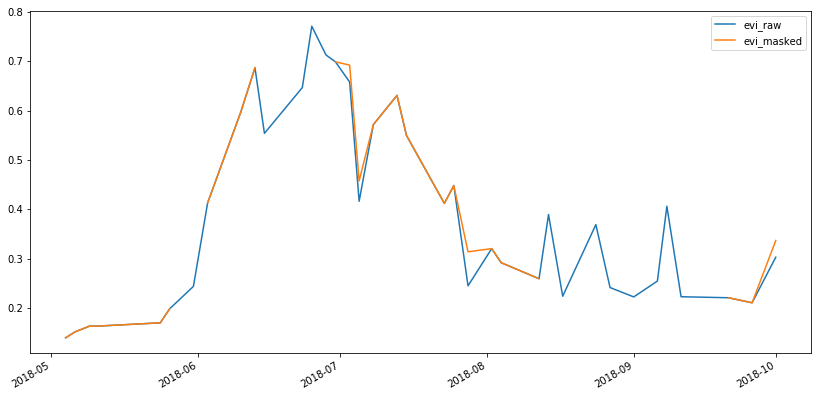

In [18]:
all_timeseries = timeseries_raw.join(timeseries_masked).dropna(how='all')
all_timeseries.index = pd.to_datetime(all_timeseries.index)
all_timeseries.plot(figsize=(14,7))
all_timeseries.head(15)

In the plot, we can see that cloud masking seems to reduce some of the variation that is found in the original raw timeseries.

## Preprocessing step 3: Time series smoothing

Cloud masking has reduced the noise in our signal, but it is clearly not perfect. This is due to the limitations of the pixel based cloud masking algorithm, which still leaves a lot of undetected bad pixels in our data.

A commonly used approach is to apply a smoothing on the timeseries. 
Here we suggest to use a 'Savitzky-Golay' filter, which we first try out locally on the aggregated timeseries, before applying to the pixels through the OpenEO API.

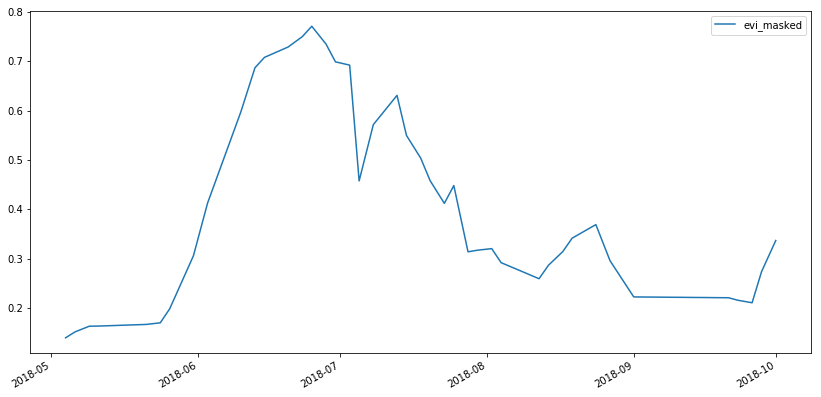

In [19]:
timeseries_masked.index = pd.to_datetime(timeseries_masked.index)
timeseries_masked.interpolate(axis=0).plot(figsize=(14,7))

Run the filter with different parameters to assess the effect.

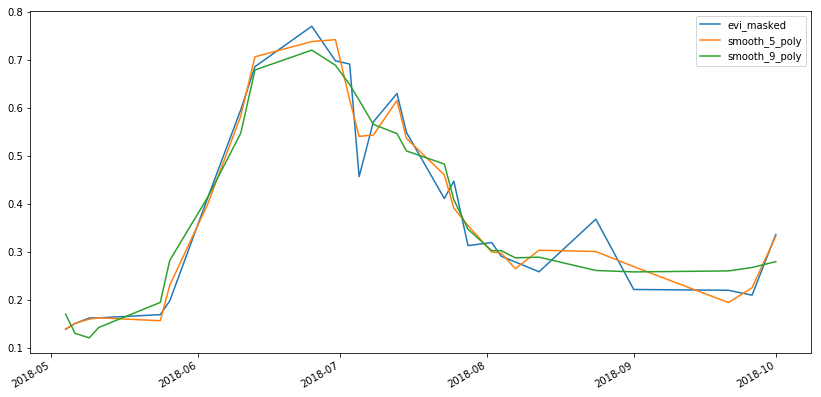

In [20]:
from scipy.signal import savgol_filter
smooth_ts = pd.DataFrame(timeseries_masked.dropna())
#smooth_ts['smooth_5'] = savgol_filter(smooth_ts.evi_masked, 5, 1)
smooth_ts['smooth_5_poly'] = savgol_filter(smooth_ts.evi_masked, 5, 2)
#smooth_ts['smooth_9'] = savgol_filter(smooth_ts.evi_masked, 9, 1)
smooth_ts['smooth_9_poly'] = savgol_filter(smooth_ts.evi_masked, 9, 2)
smooth_ts.plot(figsize=(14,7))


### Using a UDF for pixel based smoothing
The end result should be a phenology map, so we need to apply our smoothing method on the pixel values.
We use a 'user defined function' (UDF) to apply custom Python code to a datacube containging time series per pixel.

The code for our UDF function is contained in a separate file, and shown below:

In [21]:
def get_resource(relative_path):
    
    return str(Path( relative_path))
def load_udf(relative_path):
    import json
    with open(get_resource(relative_path), 'r+') as f:
        return f.read()

smoothing_udf = load_udf('udf/smooth_savitzky_golay.py')
print(smoothing_udf)

# -*- coding: utf-8 -*-
# Uncomment the import only for coding support
#from openeo_udf.api.base import SpatialExtent, RasterCollectionTile, FeatureCollectionTile, UdfData

__license__ = "Apache License, Version 2.0"


def rct_savitzky_golay(udf_data):
    from scipy.signal import savgol_filter
    import pandas as pd
    # Iterate over each tile
    for tile in udf_data.raster_collection_tiles:
        timeseries_array = tile.data
        #TODO: savitzky golay implementation assumes regularly spaced samples!

        #first we ensure that there are no nodata values in our input, as this will cause everything to become nodata.
        array_2d = timeseries_array.reshape((timeseries_array.shape[0], timeseries_array.shape[1] * timeseries_array.shape[2]))

        df = pd.DataFrame(array_2d)
        #df.fillna(method='ffill', axis=0, inplace=True)
        df.interpolate(inplace=True,axis=0)
        filled=df.as_matrix().reshape(timeseries_array.shape)

        #now apply savitzky golay on

Now we apply our udf to the temporal dimension of the datacube. Use the code block below to display the api documentation.

In [22]:
?evi_cube_masked.apply_dimension

Signature: evi_cube_masked.apply_dimension(code:str, runtime=None, version='latest', dimension='temporal') -> 'ImageCollection'
Docstring:
Applies an n-ary process (i.e. takes an array of pixel values instead of a single pixel value) to a raster data cube.
In contrast, the process apply applies an unary process to all pixel values.

By default, apply_dimension applies the the process on all pixel values in the data cube as apply does, but the parameter dimension can be specified to work only on a particular dimension only. For example, if the temporal dimension is specified the process will work on a time series of pixel values.

The n-ary process must return as many elements in the returned array as there are in the input array. Otherwise a CardinalityChanged error must be returned.


:param code: UDF code or process identifier
:param runtime:
:param version:
:param dimension:
:return:
:raises: CardinalityChangedError
File:      /data/users/Public/driesj/openeo/openeo-python-client/op

In [23]:
smoothed_evi = evi_cube_masked.apply_dimension(smoothing_udf,runtime='Python')
timeseries_smooth = smoothed_evi.polygonal_mean_timeseries(polygon)

write_graph(timeseries_smooth.graph,"timeseries_udf.json")
ts_savgol = pd.Series(timeseries_smooth.execute()).apply(pd.Series)
ts_savgol.head(10)

,0
2018-05-01T00:00:00,NaN
2018-05-04T00:00:00,NaN
2018-05-06T00:00:00,NaN
2018-05-09T00:00:00,0.161062
2018-05-11T00:00:00,0.164964
2018-05-21T00:00:00,0.164366
2018-05-24T00:00:00,0.167664
2018-05-26T00:00:00,0.209929
2018-05-31T00:00:00,0.292451
2018-06-03T00:00:00,0.434138


In [24]:
ts_savgol.dropna(inplace=True)
ts_savgol.index = pd.to_datetime(ts_savgol.index)
ts_savgol.head(10)

,0
2018-05-09,0.161062
2018-05-11,0.164964
2018-05-21,0.164366
2018-05-24,0.167664
2018-05-26,0.209929
2018-05-31,0.292451
2018-06-03,0.434138
2018-06-10,0.580032
2018-06-13,0.682960
2018-06-15,0.713623


,evi_raw,evi_masked,savgol_udf
2018-05-04,0.139695,0.139695,NaN
2018-05-06,0.151716,0.151716,NaN
2018-05-09,0.163176,0.163176,0.161062
2018-05-11,0.163503,0.163503,0.164964
2018-05-24,0.170068,0.170068,0.167664


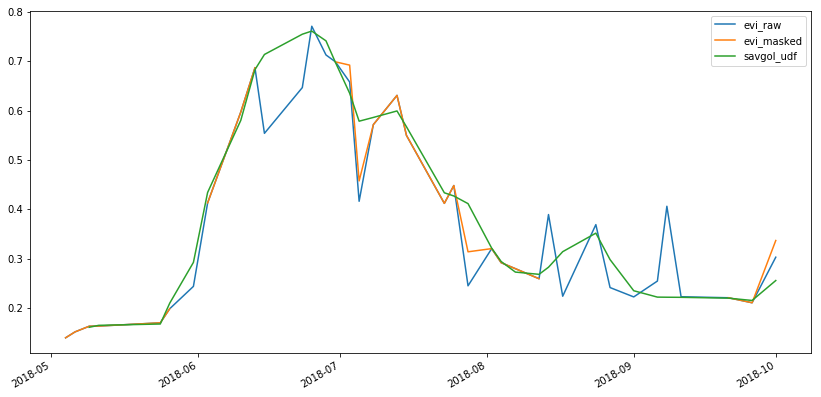

In [25]:
all_timeseries['savgol_udf'] =ts_savgol
all_timeseries.plot(figsize=(14,7))
all_timeseries.head()

This plot shows the result of applying smoothing per pixel. The noise in the timeseries seems to be reduced, but we do still need to validate if this is correct!

### To be continued...

CPU times: user 15.9 ms, sys: 5.63 ms, total: 21.5 ms
Wall time: 2min 16s


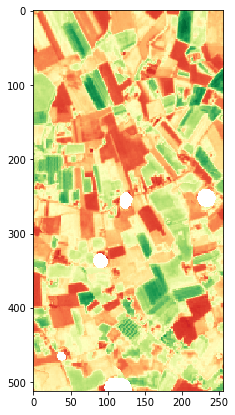

In [31]:
#smoothed_evi.filter_temporal(date,date).download("smoothed%s.tiff"%date,format='GTIFF')
show_image(smoothed_evi)